In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load and Clean Dataset

In [2]:
# # Load the dataset (replace 'songs.csv' with your actual file)
file_path = Path('Resources/spotify_dataset.csv')
songs_df = pd.read_csv(file_path)
songs_df.shape

(41099, 20)

In [3]:
# Remove duplicate songs
songs_df = songs_df.drop_duplicates(subset=['track', 'artist'], keep='first')

print(f"DataFrame after removing duplicates: {songs_df.shape}")

DataFrame after removing duplicates: (39996, 20)


In [4]:
songs_df = songs_df.reset_index(drop=True)

In [5]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39996 entries, 0 to 39995
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             39996 non-null  object 
 1   artist            39996 non-null  object 
 2   uri               39996 non-null  object 
 3   danceability      39996 non-null  float64
 4   energy            39996 non-null  float64
 5   key               39996 non-null  int64  
 6   loudness          39996 non-null  float64
 7   mode              39996 non-null  int64  
 8   speechiness       39996 non-null  float64
 9   acousticness      39996 non-null  float64
 10  instrumentalness  39996 non-null  float64
 11  liveness          39996 non-null  float64
 12  valence           39996 non-null  float64
 13  tempo             39996 non-null  float64
 14  duration_ms       39996 non-null  int64  
 15  time_signature    39996 non-null  int64  
 16  chorus_hit        39996 non-null  float6

In [6]:
# Normalize dataset columns for searching
songs_df['track_lower'] = songs_df['track'].str.strip().str.lower()
songs_df['artist_lower'] = songs_df['artist'].str.strip().str.lower()

In [7]:
songs_df.shape

(39996, 22)

### Get Dummies for Decade Column

In [8]:
# Create dummy variables for the 'decade' column
decade_dummies = pd.get_dummies(songs_df['decade'], prefix='decade')

# Concatenate the dummy variables with the original DataFrame
songs_df = pd.concat([songs_df, decade_dummies], axis=1)

# Drop the original 'decade' column 
songs_df.drop('decade', axis=1, inplace=True)

In [9]:
songs_df.shape

(39996, 27)

In [10]:
songs_df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,sections,popularity,track_lower,artist_lower,decade_00s,decade_10s,decade_60s,decade_70s,decade_80s,decade_90s
0,Jealous Kind Of Fella,Garland Green,spotify:track:1dtKN6wwlolkM8XZy2y9C1,0.417,0.620,3,-7.727,1,0.0403,0.490,...,9,1,jealous kind of fella,garland green,False,False,True,False,False,False
1,Initials B.B.,Serge Gainsbourg,spotify:track:5hjsmSnUefdUqzsDogisiX,0.498,0.505,3,-12.475,1,0.0337,0.018,...,10,0,initials b.b.,serge gainsbourg,False,False,True,False,False,False
2,Melody Twist,Lord Melody,spotify:track:6uk8tI6pwxxdVTNlNOJeJh,0.657,0.649,5,-13.392,1,0.0380,0.846,...,12,0,melody twist,lord melody,False,False,True,False,False,False
3,Mi Bomba Sonó,Celia Cruz,spotify:track:7aNjMJ05FvUXACPWZ7yJmv,0.590,0.545,7,-12.058,0,0.1040,0.706,...,8,0,mi bomba sonó,celia cruz,False,False,True,False,False,False
4,Uravu Solla,P. Susheela,spotify:track:1rQ0clvgkzWr001POOPJWx,0.515,0.765,11,-3.515,0,0.1240,0.857,...,14,0,uravu solla,p. susheela,False,False,True,False,False,False


# Determine Which Features to Use

In [11]:
songs_df['instrumentalness'].describe()

count    39996.000000
mean         0.153977
std          0.303240
min          0.000000
25%          0.000000
50%          0.000117
75%          0.059700
max          1.000000
Name: instrumentalness, dtype: float64

Many songs have an instrumentalness of 0, and 75% have a number that is very small, so i decided to not include instrumentalness as one of my features. 

In [12]:
popular_songs_count = songs_df[songs_df['popularity'] == 1].shape[0]

print(f"There are {popular_songs_count} popular songs in the dataset.")

There are 20125 popular songs in the dataset.


If I use popular songs in a feature, the model will only pick other songs that are popular, so it will cut the dataset in half. And if I include the  different decades in the model, the model will only recommend songs from the input songs decade, which I want to avoid. 

## Features and Scaling

In [13]:
features = [
# 'track',
#  'artist',
#  'uri',
 'danceability',
 'energy',
#  'key',
#  'loudness',
#  'mode',
#  'speechiness',
 'acousticness',
#  'instrumentalness',
#  'liveness',
 'valence',
 'tempo',
#  'duration_ms',
#  'time_signature',
#  'chorus_hit',
#  'sections',
#  'popularity',
#  'decade_60s',
#  'decade_70s',
#  'decade_80s',
#  'decade_90s',
#  'decade_00s',
#  'decade_10s'
 ]


X = songs_df[features]

In [14]:
scaler = MinMaxScaler()

# Ensure indices of scaled features match songs_df
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=features,
    index=songs_df.index  # Match the original index
)

In [15]:
X_scaled.head()

,danceability,energy,acousticness,valence,tempo
0,0.422065,0.619905,0.491968,0.848394,0.769003
1,0.504049,0.504876,0.018072,0.800201,0.421671
2,0.664980,0.648912,0.849398,0.911647,0.480236
3,0.597166,0.544886,0.708835,0.970884,0.437373
4,0.521255,0.764941,0.860442,0.909639,0.474756


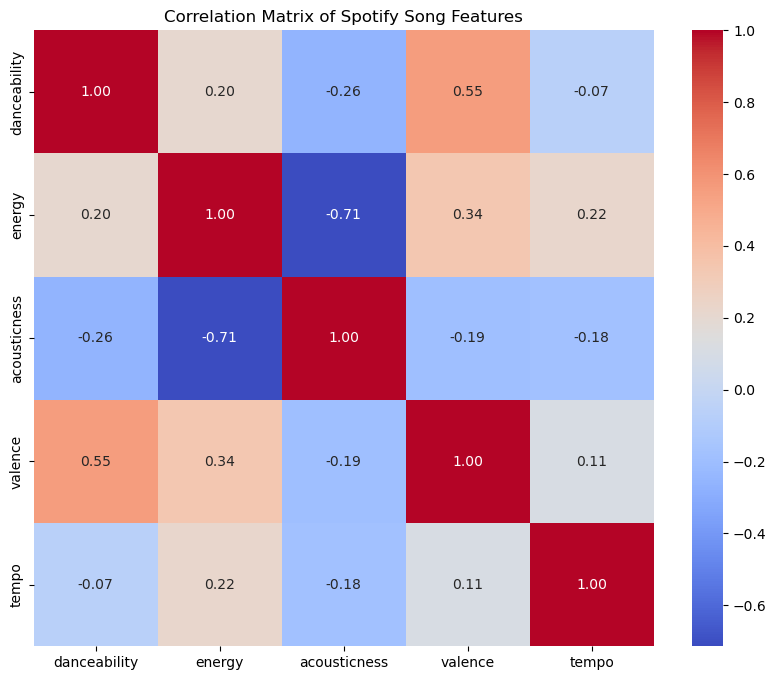

In [16]:
correlation_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Spotify Song Features")
plt.show()

## Apply Weights

In [17]:
# Feature weighting
weights = {
    'danceability': 1.0,
    'energy': 1.3,
    'acousticness': 1.0,
    # 'liveness': 1.3,
    'valence': 1.3,
    'tempo': 1.0,
}

In [18]:
# Apply the weights to the scaled features
weighted_features = X_scaled * pd.Series(weights)

In [19]:
weighted_features.head()

,danceability,energy,acousticness,valence,tempo
0,0.422065,0.805876,0.491968,1.102912,0.769003
1,0.504049,0.656338,0.018072,1.040261,0.421671
2,0.664980,0.843585,0.849398,1.185141,0.480236
3,0.597166,0.708351,0.708835,1.262149,0.437373
4,0.521255,0.994423,0.860442,1.182530,0.474756


# NN Model

In [20]:
# Train a k-Nearest Neighbors model
model = NearestNeighbors(n_neighbors=20, algorithm='ball_tree')
model.fit(weighted_features)

NearestNeighbors(algorithm='ball_tree', n_neighbors=20)

# Bar Chart

In [21]:
def visualize_features(original_features, recommendation_features, feature_names, song_title, artist_name):

    plt.style.use('default')

    # Identify indices of the decade features
    decade_indices = [i for i, name in enumerate(feature_names) if 'decade_' in name]

    # Create a mask to filter out the decade features
    mask = np.ones(len(feature_names), dtype=bool)
    mask[decade_indices] = False  # Set decade features to False

    # Filter original and recommendation features
    filtered_original_features = original_features[0, mask]
    filtered_recommendation_features = np.array(recommendation_features)[:, mask].mean(axis=0)
    filtered_feature_names = [feature_names[i] for i in range(len(feature_names)) if mask[i]]

    # Prepare the x-axis
    x = np.arange(len(filtered_feature_names))

    plt.figure(figsize=(10, 6))
    plt.bar(x - 0.2, filtered_original_features, width=0.4, label=f"{song_title} by {artist_name}", color='#e83f1e') 
    plt.bar(x + 0.2, filtered_recommendation_features, width=0.4, label="Recommended Songs (Average)", color='#419edf') 
    
    plt.xticks(x, filtered_feature_names, ha='center')
    plt.title(f"{song_title} by {artist_name} vs Recommendations", fontsize=14, fontweight='bold')
    plt.ylabel("Scaled Feature Values", fontsize=12)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

# HTML Code

In [22]:
from IPython.display import HTML

def convert_uri_to_url(uri):
    if isinstance(uri, str) and uri.startswith("spotify:track:"):
        track_id = uri.split(":")[2]
        return f"https://open.spotify.com/track/{track_id}"
    return None  # Return None for invalid URIs

# Add 'url' column to the DataFrame
songs_df['url'] = songs_df['uri'].apply(convert_uri_to_url)

# Final Function

In [23]:
def recommend_songs(song_title, artist_name, num_recommendations=5):
    # Preprocess input
    song_title = song_title.strip().lower()
    artist_name = artist_name.strip().lower()

    # Filter the dataset for the input song and artist
    song_row = songs_df[
        (songs_df['track_lower'].str.contains(song_title)) & 
        (songs_df['artist_lower'].str.contains(artist_name))
    ]
    
    if song_row.empty:
        print(f"Error: Song '{song_title}' by '{artist_name}' not found in the dataset.")
        return

    # Get the index and weighted features of the input song
    song_index = song_row.index[0]
    song_features = weighted_features.loc[song_index].values.reshape(1, -1)

    # Convert to DataFrame with correct feature names
    song_features_df = pd.DataFrame(song_features, columns=weighted_features.columns)

    # Find nearest neighbors
    distances, indices = model.kneighbors(song_features_df)
    
    # Map indices back to the original DataFrame
    recommendations = []
    recommendation_features = []  # Store features of recommended songs

    for i in indices.flatten():
        original_index = songs_df.index[i]  # Map to original index
        if (songs_df.loc[original_index, 'track_lower'] != song_row.iloc[0]['track_lower'] and 
            songs_df.loc[original_index, 'artist_lower'] != song_row.iloc[0]['artist_lower']):
            recommendations.append((
                songs_df.loc[original_index, 'track'],
                songs_df.loc[original_index, 'artist'],
                songs_df.loc[original_index, 'url']  # Add the URL
            ))
            recommendation_features.append(weighted_features.loc[original_index].values)  # Add weighted features
        if len(recommendations) >= num_recommendations:
            break

    # Print recommendations with clickable Spotify links
    original_song = song_row.iloc[0]['track']
    original_artist = song_row.iloc[0]['artist']
    
    print(f"Recommendations for '{original_song}' by {original_artist}:")
    for track, artist, url in recommendations:
        display(HTML(f"- <a href='{url}' target='_blank'>{track} by {artist}</a>"))

    # Visualize features comparison
    visualize_features(
        song_features, recommendation_features, weighted_features.columns, original_song, original_artist
    )

    pd.set_option('display.max_colwidth', None) 
    return pd.DataFrame(recommendations, columns=["Track", "Artist", "URL"])

# User Input

Recommendations for 'Wild Horses' by The Rolling Stones:


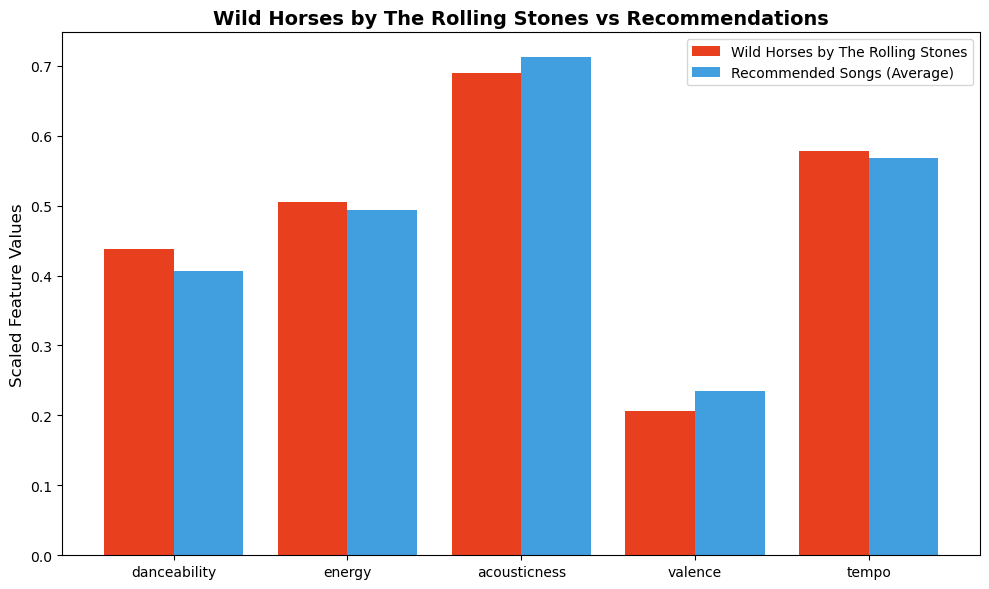

,Track,Artist,URL
0,Bring On The Rain,Jo Dee Messina With Tim McGraw,https://open.spotify.com/track/1OnXz5v4hVdrNLJ9N4MqzL
1,Always And Forever,Luther Vandross,https://open.spotify.com/track/3xvcFlh6hHqxyiAFkqpsjZ
2,If I Only Had Time,Andy Tielman,https://open.spotify.com/track/4bBGRlNl2zkBFPftFxW375
3,New Horizons,The Don Ellis Orchestra,https://open.spotify.com/track/1HyfKIkVkKr7E1aprb2uum
4,Patricia Anglaia,Kayak,https://open.spotify.com/track/2frvH9u73udOJ5fcBY70qy
5,Big 'O',Elmer Bernstein,https://open.spotify.com/track/1bpGmklMjUdJyD70gF8nxI
6,Every Time You Touch Me (I Get High),Charlie Rich,https://open.spotify.com/track/3ydvQ1vczAWHdXA5h9yToW
7,I Believe You,Carpenters,https://open.spotify.com/track/6mYCs04NSlCQuZokTNj3DH
8,I Believe,Diamond Rio,https://open.spotify.com/track/6cTZQGs1U5xkWA1fgLc8tH
9,Lonely Fire,Miles Davis,https://open.spotify.com/track/37svRwK7eSg95EEdqEACl7


In [24]:
recommend_songs("wild horses", "rolling", 10)

The bar graph evaluates model accuracy by comparing predictions to actual values, highlighting strengths and areas for improvement.

Recommendations for 'Take It Easy' by Eagles:


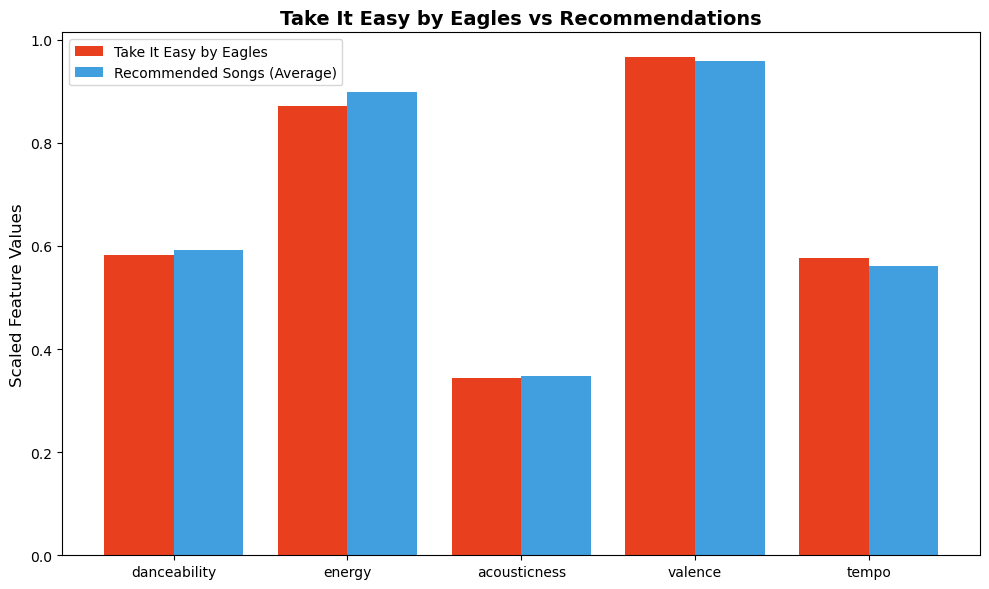

,Track,Artist,URL
0,Good Combination,Sonny & Cher,https://open.spotify.com/track/5YRBpKTf5lKBy9jYS2TDCn
1,Dinah Flo,Boz Scaggs,https://open.spotify.com/track/7xFA8p9ZhpoSFRlr9NawLv
2,I'm Gonna Be (500 Miles),The Proclaimers,https://open.spotify.com/track/3kYnliVTDOrBKXm4DS1icg
3,Just Another Day In Paradise,Phil Vassar,https://open.spotify.com/track/4LlNoNZflek4hZyZigCxpW
4,Raate Sapna,Kanchan,https://open.spotify.com/track/6sCD4qBO5y6IYbHAvjhKbi
5,Whiskey Glasses,Morgan Wallen,https://open.spotify.com/track/6foY66mWZN0pSRjZ408c00
6,El Dios De Israel Es Poderoso,Palabra en Acción,https://open.spotify.com/track/6UIyQwhvmx8VuAVtMJeL8O
7,Não Marque as Horas,Cátia de França,https://open.spotify.com/track/5Pw3EOLqgOetvpyXITNH4M
8,Love And Happiness / Soul Man - Live / 1983,Otis Clay,https://open.spotify.com/track/4WYakVfLXpjKkonAgSqxpJ
9,P.S. I Love You,The Beatles,https://open.spotify.com/track/7Msq9qojB7yORuJvz49iUy


In [25]:
recommend_songs("easy", "eagles", 10)

Recommendations for 'Before He Cheats' by Carrie Underwood:


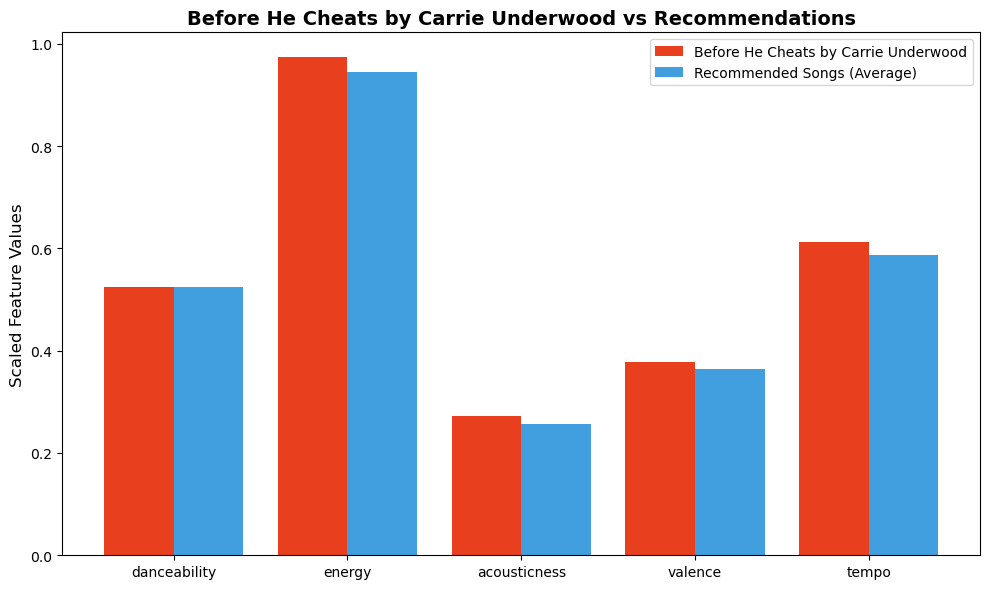

,Track,Artist,URL
0,Silence,Marshmello Featuring Khalid,https://open.spotify.com/track/7vGuf3Y35N4wmASOKLUVVU
1,That's What Love Is For,Amy Grant,https://open.spotify.com/track/367dmPOxuMP8FsrZHenNnq
2,Didn't You Know How Much I Loved You,Kellie Pickler,https://open.spotify.com/track/3ySlOXQ77aZd5NLu0H0Ddc
3,Like My Mother Does,Lauren Alaina,https://open.spotify.com/track/7t8oQycrEftd8NuWdCcfQb
4,Drugs Or Jesus,Tim McGraw,https://open.spotify.com/track/56DXpIS5RAMfRFs2mVcjf7
5,Do I,Luke Bryan,https://open.spotify.com/track/7A5CReD6yWe0rrkJym34QI
6,Part Of The Problem,R. Stevie Moore,https://open.spotify.com/track/7HPzwsJiZAsrM5U1KMGleZ
7,If This Was A Movie,Taylor Swift,https://open.spotify.com/track/0vvt4IZOMkRug195S4MUq0
8,Something To Believe In,Poison,https://open.spotify.com/track/7pUYjnFTXMs0mFWsE9epqV
9,Amen,Meek Mill Featuring Drake,https://open.spotify.com/track/32UIpKdyGzgTPTO8e5ge5c


In [26]:
recommend_songs("before he", "carrie", 10)

Recommendations for 'Back At One' by Brian McKnight:


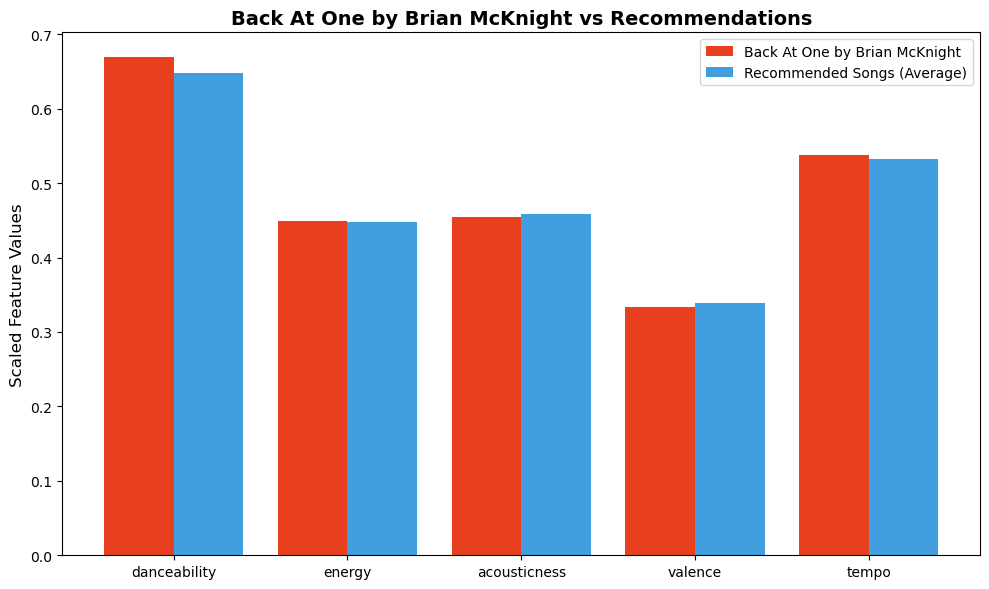

,Track,Artist,URL
0,Ooh La La (I Can't Get Over You),Perfect Gentlemen,https://open.spotify.com/track/2obTnCmXErghJPwnXFw4tV
1,Love Me,Tracie Spencer,https://open.spotify.com/track/0Q7aNolyWuEFAk53EGql50
2,Colder Weather,Zac Brown Band,https://open.spotify.com/track/1M2l9ReoabUnvl6Y8jLUe7
3,Pete Davidson,Ariana Grande,https://open.spotify.com/track/0XOnMqLQDO89iAg7dWWwnG
4,When You Walk In The Room,Jackie DeShannon,https://open.spotify.com/track/4uK6BtqhRoEaZopGJ6FCef
5,Imagine,Tracie Spencer,https://open.spotify.com/track/5dJeloBIxmZiqCUexEJxbX
6,Live To Tell,Madonna,https://open.spotify.com/track/095MMFhB9qxPx2VsmvjnUs
7,Thinkin Bout You,Frank Ocean,https://open.spotify.com/track/7DfFc7a6Rwfi3YQMRbDMau
8,Like Jesus Does,Eric Church,https://open.spotify.com/track/3wxgj5N8ZKoZWHDw6FJUf2
9,Shower Me With Your Love,Surface,https://open.spotify.com/track/0YL8rCxASTV9uBE9Sur0Ag


In [27]:
recommend_songs("back at one", "Brian", 10)